<a href="https://colab.research.google.com/github/shintafiaa/Teaching-Assistant-Technobar/blob/main/Technobar/6_XGBoost_data_melb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Terryanda Naufaldo Arhaby**

## **1103213107**

## **Machine Learning Week 7 Data Melb**

In [3]:
!pip install matplotlib shap scikit-learn
!pip install -U scikit-learn

Learn on how to build and optimize model with **gradient boosting.**

#Introduction
By definition, **ensemble methods** combine the predictions of several models (e.g., several trees, in the case of random forest).

Now, we'll learn about another ensemble method called gradient boosting.

#Difference of Decision Tree, Random Forest, and XGBoost

1. Decision Tree:
A decision tree is a simple and interpretable model that recursively splits the data into subsets based on the feature values. It forms a tree-like structure where each internal node represents a test on a feature, each branch represents the outcome of that test, and each leaf node represents the final prediction. The decision tree makes binary decisions at each node to split the data. It is prone to overfitting, especially when the tree becomes deep, capturing noise and leading to poor generalization on unseen data.

2. Random Forest:
Random Forest is an ensemble learning method that builds multiple decision trees and combines their predictions through voting (for classification) or averaging (for regression). Each decision tree is trained on a random subset of the data (bootstrap sample) and a random subset of the features. This randomness reduces overfitting and increases the model's ability to generalize to new data.

3. XGBoost (Extreme Gradient Boosting):
XGBoost is an optimized implementation of the Gradient Boosting algorithm. It creates an ensemble of weak learners (usually shallow decision trees) sequentially, where each new model corrects the errors made by the previous one. XGBoost uses a gradient-based optimization algorithm to minimize a loss function while adding new trees to the ensemble. It also includes regularization terms to control overfitting and speed up the training process. XGBoost is known for its high performance, scalability, and efficiency, making it popular in various machine learning competitions and real-world applications.
**XGBoost** is an implementation of gradient boosting with several additional features focused on perfmance and speed. The final result of an XGBoost model is a weighted sum of the predictions made by all the individual trees in the sequence. The contribution of each tree is adjusted during training based on how well it reduces the overall error.


Note:

* Regularization (penyederhanaan): XGBoost introduces regularization terms to control overfitting during the training process. Regularization helps prevent the model from becoming too complex and ensures better generalization to unseen data.


#Gradient Boosting

**Gradient boosting** is a method that goes through cycles to iteratively add models into an ensemble (setelan).

It begins by initializing the ensemble with a single model, whose predictions can be pretty naive. (Even if its predictions are wildly inaccurate, subsequent (kemudian) additions to the ensemble will address those errors.)

Then, we start the cycle:
1. First, we use the current ensemble to generate predictions for each observation in the dataset. To make a prediction, we **add the predictions from all models** in the ensemble.
2. These predictions are used to calculate a loss function (like mean squared error, for instance).
3. Then, we use the loss function to fit a new model that will be added to the ensemble. Specifically, we determine model parameters so that adding this new model to the ensemble will reduce the loss.
4. Finally, we add the new model to ensemble, and ...
5. Repeat!

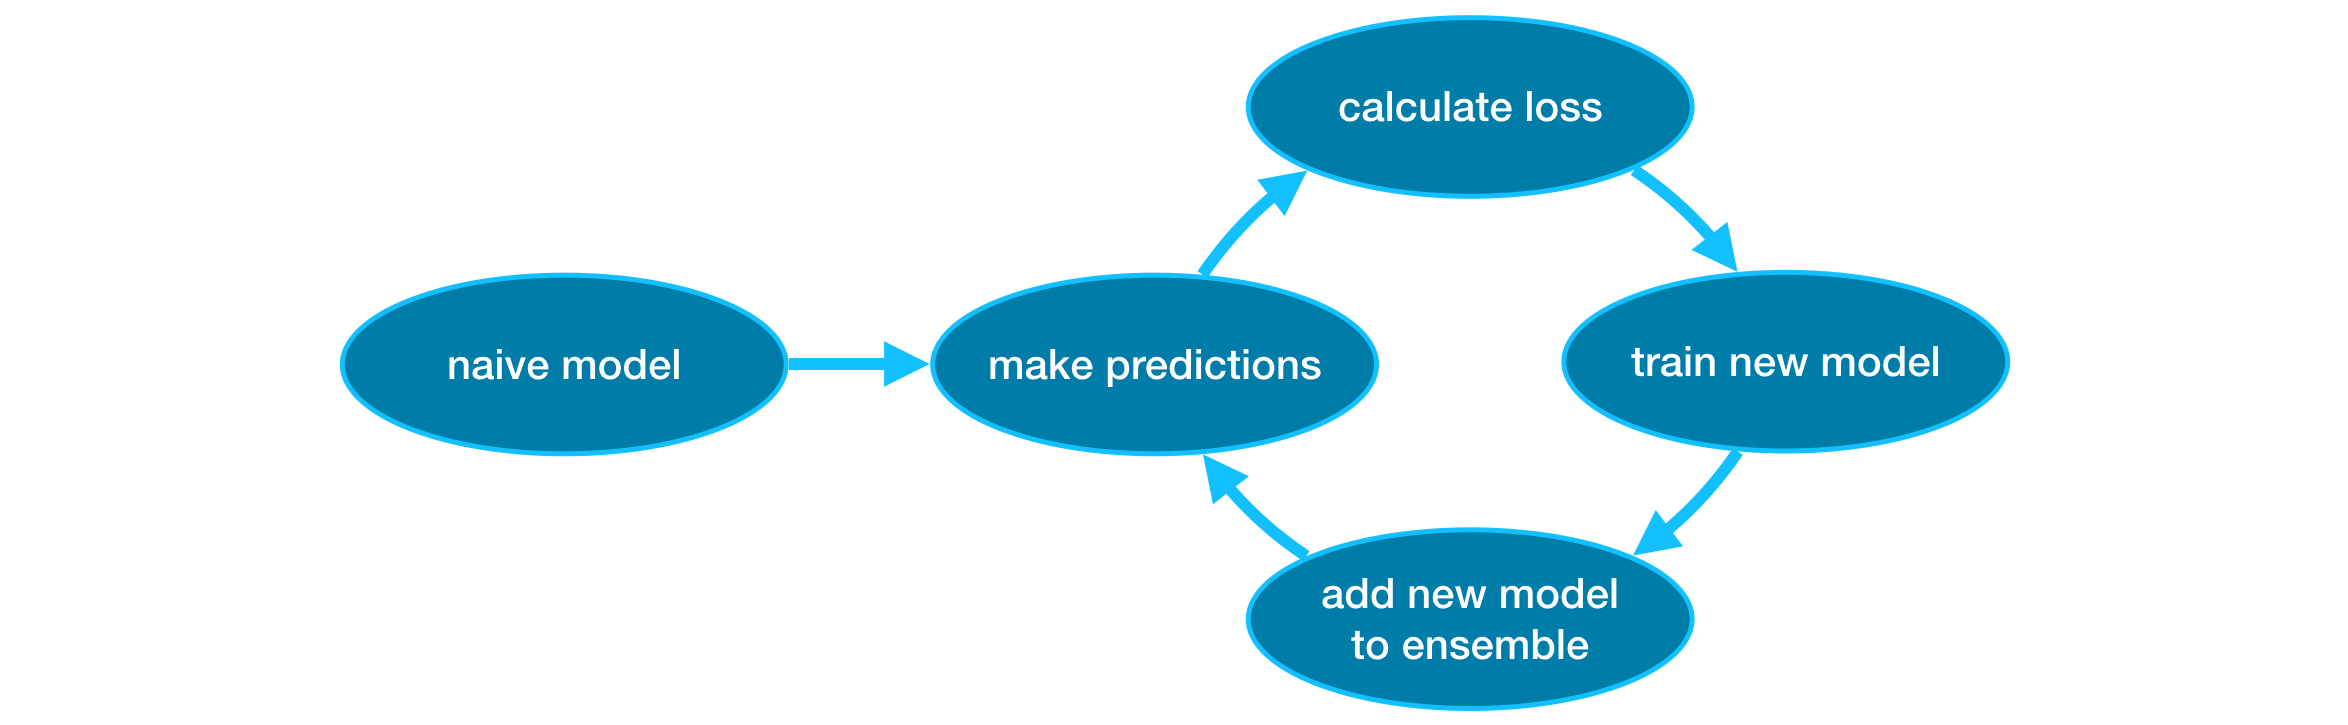

#Example
We begin by loading the training and validation data in X_train, X_valid, y_train, y_valid.

**Prompt:**

Write a code cell to mount Google Drive in Colab.

In [5]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.inspection import PartialDependenceDisplay
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import DMatrix, train
from xgboost import plot_tree
from xgboost import plot_importance

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Prompt:**

Write a code cell to read a CSV file from Google Drive into a DataFrame.

In [6]:
# Replace 'your-folder-path/your-file.csv' with the actual path to your CSV file in Google Drive
file_path = '/content/drive/MyDrive/Dataset/melb_data.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


**Prompt:**

Write a code cell to select a subset of predictors ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt'] and set the target variable ['Price'] from the DataFrame.

In [7]:
# Selecting predictors
predictors = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
X = df[predictors]

# Setting the target variable
y = df['Price']

# Displaying the first few rows of the predictors and target variable
X.head(), y.head()

(   Rooms  Distance  Landsize  BuildingArea  YearBuilt
 0      2       2.5     202.0           NaN        NaN
 1      2       2.5     156.0          79.0     1900.0
 2      3       2.5     134.0         150.0     1900.0
 3      3       2.5      94.0           NaN        NaN
 4      4       2.5     120.0         142.0     2014.0,
 0    1480000.0
 1    1035000.0
 2    1465000.0
 3     850000.0
 4    1600000.0
 Name: Price, dtype: float64)

**Prompt:**

Write a code cell to split the data into training and validation

In [8]:
# Splitting the data into training and validation sets (e.g., 80% training, 20% validation)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

# Displaying the sizes of the training and validation sets
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((10864, 5), (2716, 5), (10864,), (2716,))

In the next code cell, we import the scikit-learn API for XGBoost (`xgboost.XGBRegressor`). As you'll see in the output, the `XGBRegressor` class has many tunable parameters.


**Prompt:**

Write a code cell to train the model using XGBoost, and print the mean absolute error on the validation set.

In [9]:
# Define the model with a random seed for reproducibility
model = XGBRegressor(random_state=0)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the validation set
predictions = model.predict(X_valid)

# Calculate the mean absolute error
mae = mean_absolute_error(y_valid, predictions)
print("Mean Absolute Error on validation set:", mae)

Mean Absolute Error on validation set: 235734.8582991992


We also make predictions and evaluate the model.

#Parameter Tuning
XGBoost has a few parameters that can dramatically affect accuracy and training speed. The first parameters you should understand are:

`n_estimators`
Specifies how many times to go through the modeling cycle described above. It is equal to the number of models that we include in the ensemble.
* Too low a value causes underfitting, which leads to inaccurate predictions on both training data and test data.
* Too high a value causes overfitting, which causes accurate predictions on training data, but inaccurate predictions on test data (which is what we care about).

Typical values range from 100-1000, though this depends a lot on the `learning_rate` parameter discussed below.

Here is the code to set the number of models in the ensemble:

**Prompt:**

Write a code cell to create another XGBRegressor with 500 estimators, train it, and print the mean absolute error on the validation set.

In [10]:
# Define the model with 500 estimators and a random seed for reproducibility
model_500 = XGBRegressor(n_estimators=500, random_state=0)

# Train the model
model_500.fit(X_train, y_train)

# Make predictions on the validation set
predictions_500 = model_500.predict(X_valid)

# Calculate the mean absolute error
mae_500 = mean_absolute_error(y_valid, predictions_500)
print("Mean Absolute Error on validation set with 500 estimators:", mae_500)

Mean Absolute Error on validation set with 500 estimators: 242472.02245446545


The MAE result of the model with n_estimators set to 500 turned out to be greater than the default value of n_estimators, which is 100.

The MAE (Mean Absolute Error) of the model with an n_estimators value of 110 turns out to be smaller than the default n_estimators value of 100, as well as n_estimators with a value of 500.

`early_stopping_rounds`
offers a way to automatically find the ideal value for `n_estimators`. Early stopping causes the model to stop iterating when the validation score stop improving, even if we aren't the hard stop for `n_estimators`. It's smart to set a high value for `n_estimators` and then use `early_stopping_rounds` to find the optimal time to stop iterating.

Since random chance sometimes causes a single round where validation scores don't improve, you need to specify a number for how many rounds of straight deterioration (keburukan) to allow before stopping. Setting `early_stopping_rounds=5` is a reasonable choice. In this case, we stop after 5 straight rounds of deteriorating validation scores.

When using `early_stopping_rounds`, you also need to set aside some data for calculating the validation scores. This is done by setting the `eval_set` parameter.

We can modify the example above to include early stopping.

---
Note:

* In the context of training machine learning models, "deteriorating" refers to a situation where the performance of the model on a validation dataset worsens over consecutive iterations during the training process. Typically, we monitor a metric (such as accuracy, mean squared error, etc.) on the validation dataset to evaluate the model's performance.

* In the given code, verbose=False is an argument passed to the fit method of the XGBRegressor model. Setting verbose to False means that during the training process, the model will not produce any output or progress messages. It will train silently without displaying information about each boosting round.

`n_jobs`

On larger datasets where runtime is a consideration, you can use parallelism to build your model faster. It's common to set the parameter `n_jobs` equal to the number of cores on your machine. On smaller datasets, this won't help.
The resulting model won't be any better, so micro-optimizing for fitting time is typically nothing but a distraction. But, it's useful in large datasets where you would otherwise spend a long time waiting during the `fit` command.

Here's the modified example.

**Prompt:**

Write a code cell to train an XGBRegressor with a custom learning rate, 90 estimators, and early stopping rounds, and print the mean absolute error on the validation set.

In [12]:
# Create DMatrix for training and validation
dtrain = DMatrix(X_train, label=y_train)
dvalid = DMatrix(X_valid, label=y_valid)

# Set parameters, including the custom learning rate
params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.05,
    "seed": 0
}

# Train the model with early stopping
model_custom = train(
    params,
    dtrain,
    num_boost_round=90,
    evals=[(dvalid, "validation")],
    early_stopping_rounds=10,
    verbose_eval=False
)

# Make predictions on the validation set
predictions_custom = model_custom.predict(dvalid)

# Calculate the mean absolute error
mae_custom = mean_absolute_error(y_valid, predictions_custom)
print("Mean Absolute Error on validation set with custom learning rate and 90 estimators:", mae_custom)

Mean Absolute Error on validation set with custom learning rate and 90 estimators: 251693.55793216126


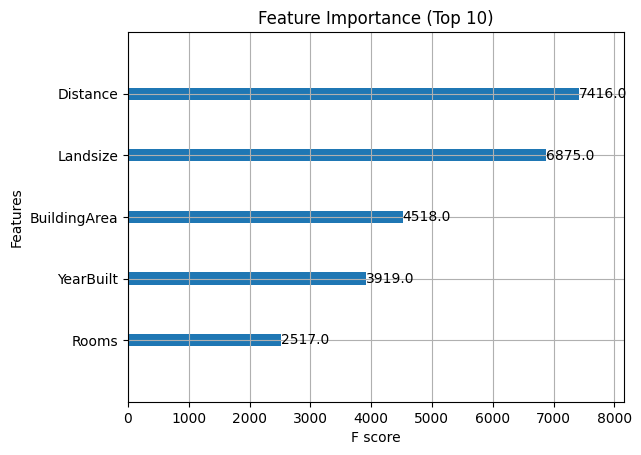

In [13]:
# Plot feature importance
plot_importance(model_500, importance_type='weight', max_num_features=10)
plt.title("Feature Importance (Top 10)")
plt.show()

<Figure size 2000x1000 with 0 Axes>

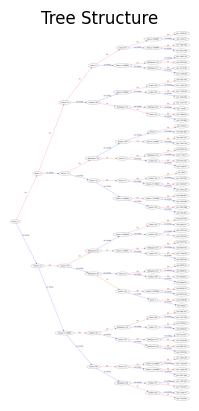

In [14]:
# Plot the first tree in the model
plt.figure(figsize=(20, 10))
plot_tree(model_500, num_trees=0, rankdir='LR')  # Change num_trees as needed
plt.title("Tree Structure")
plt.show()

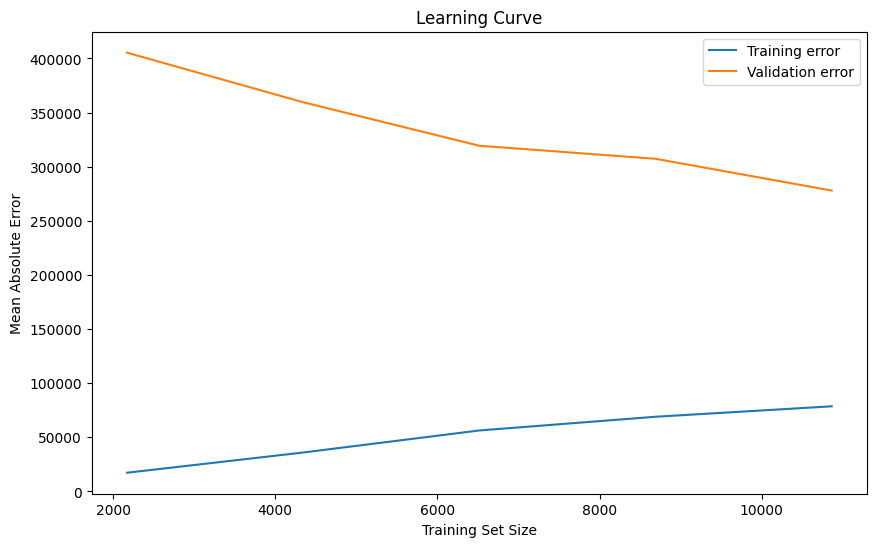

In [15]:
# Calculate the learning curve
train_sizes, train_scores, valid_scores = learning_curve(
    model_500, X, y, train_sizes=[0.2, 0.4, 0.6, 0.8, 1.0], cv=5, scoring='neg_mean_absolute_error')

# Calculate the mean and standard deviation for training and validation scores
train_scores_mean = -train_scores.mean(axis=1)
valid_scores_mean = -valid_scores.mean(axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Training error")
plt.plot(train_sizes, valid_scores_mean, label="Validation error")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Absolute Error")
plt.title("Learning Curve")
plt.legend()
plt.show()

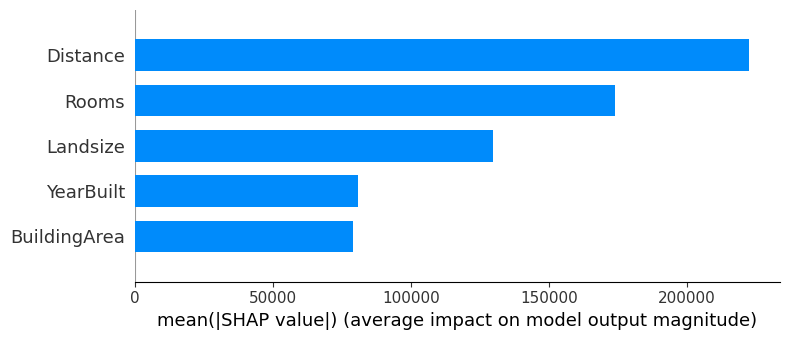

In [16]:
# Create SHAP explainer
explainer = shap.TreeExplainer(model_500)
shap_values = explainer.shap_values(X_valid)

# Plot summary SHAP values
shap.summary_plot(shap_values, X_valid, plot_type="bar")

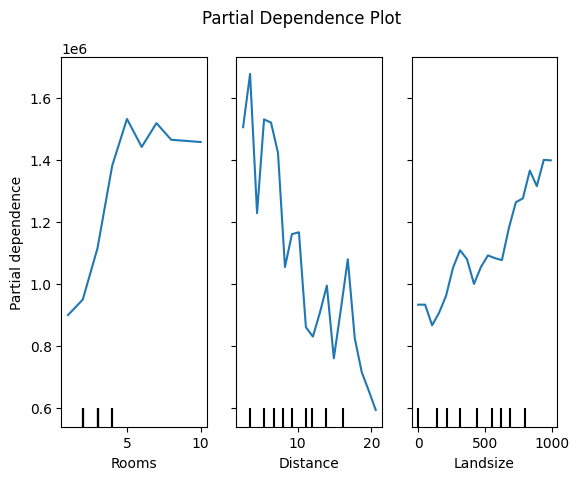

In [17]:
# Tentukan fitur yang akan dibuat partial dependence plot
features = ['Rooms', 'Distance', 'Landsize']

# Buat partial dependence plot
PartialDependenceDisplay.from_estimator(model_500, X_train, features, grid_resolution=20)
plt.suptitle("Partial Dependence Plot")
plt.show()